<a href="https://colab.research.google.com/github/aymuos/masters-practise-repo/blob/main/TSA_Nifty_50_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **# Group - 8**

**CH24M548 - Mounika Chowdary Pamulapati**

**CH24M571 - Soumya Mukherjee**

**CH24M577 - Surya Kandala**

The steps followed to model the given Nifty 50 data were the below:

1. **Importing the dataset**.
2. **Statistical Distribution** of the data.
3. **Checking for Outliers** - Box Plot
4. **Cleaning the dataset**: Ensured that missing dates were added and forward fill of the data for the missing dates. Dropped NaN records whereever observed.
5. **Stationarity Check**: Validated if the timeseries is stationary or not by performing ADF test. For ADF test if p < 0.05, then it says the timeseries is stationary.
6. **First Order Differencing & Log Differencing**: Performing first order differencing to make the timeseries stationary.
7. Check for **Seasonality and anamolies** - Heat Map
8. Check if the **differenced data** is following **Gaussian Distribution** by plotting Bar graph.
9. Check the **variability of Variance** if its varying with **absolute time**.
10. **ACF and PACF**: Compute Auto Correlation and Partial correlation to understand the presence of MA and AR components.
11. **Power Spectral Density**: Frequency domain analysis of the timeseries data

12. **Random Walk with Drift**: Based on the ACF and PACF values, going with ARMA model of 010 since ACF and PACF results indicate complete white noise.

13. **Akaike's Information Criteria - ARIMA**: Since the forecast is only a straight line, checked the AIC values for a set of models and choose that model which has less AIC value
14. **Train, Test & Generate Forecast**: Generated the forecast for 122 ARIMA model which got less AIC value in step 12.
15. Plot the **Residuals**
16. **MSE, RMSE, R^2 and MAPE**: Identify the Mean Square Error and Root Mean Square Error to check the residual details.

17. Akaike's Information Criteria - **SARIMA** - Though ARIMA predicted appropriate trend, its still missing seASONALITY. So, identifying appropriate seasonality order of the data again based on least AIC value.
18. **Train, Test & Generate Forecast**: Generated the forecast for SARIMAX(3,2,0) & Seasonal order (2,1,0) model which got less AIC value in step 15.
19. Plot the **Residuals**
20. **MSE, RMSE, R^2 and MAPE**: Identify the Mean Square Error and Root Mean Square Error, R^2 and MAPE to check the residual details. Also, compare it with the previous values and check if the errors are reduced.

21. **Alternate Non-Linear models**: Since we have variance as a function of absolute time, linear models might not be the right choice to move ahead, hence trying out the LSTM and Prophet models.

Packages Required!

In [309]:
!pip install pandas numpy matplotlib seaborn statsmodels scipy scikit-learn arch statsforecast dask[dataframe] pmdarima keras

In [310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.sandbox.stats.runs import runstest_1samp
from arch import arch_model
from statsforecast import StatsForecast
import pmdarima as pm
import warnings
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

**Importing the dataset**:

Reading the Training dataset from Google Drive and set the date field as index.

In [311]:
# Generate or load your Training dataset
url='https://drive.google.com/file/d/16h5NCff5s-2V9lwksc9aCEKJIAn2Znyv/view?usp=drive_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
# df = pd.read_csv('NIFTY_50_2015-2023.csv')
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df.set_index('Date', inplace=True)

df.head()

,Open,High,Low,Close,Shares Traded,Turnover (? Cr),Year,Month
Date,,,,,,,,
2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17,2015,11
2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47,2015,11
2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,2015,11
2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,2015,11
2015-11-16,7732.95,7838.85,7714.15,7806.60,154134885.0,6871.15,2015,11


In [312]:
# Import Test dataset

url='https://drive.google.com/file/d/1L-hcnQLVffdxz1PwwMTJkB6AmB2BkjBn/view?usp=drive_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_test = pd.read_csv(url)
## df_test = pd.read_csv('NIFTY_50_2024.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='mixed')
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.set_index('Date', inplace=True)


df_test.head()

,Open,High,Low,Close,Shares Traded,Turnover (? Cr)
Date,,,,,,
2024-01-01,21727.75,21834.35,21680.85,21741.90,153995217.0,14184.09
2024-01-02,21751.35,21755.60,21555.65,21665.80,263711568.0,25316.13
2024-01-03,21661.10,21677.00,21500.35,21517.35,311933117.0,32329.23
2024-01-04,21605.80,21685.65,21564.55,21658.60,339172697.0,30868.15
2024-01-05,21705.75,21749.60,21629.20,21710.80,309303266.0,26554.49


**Statistical Description** of Train and Test datasets

In [313]:
# Statistical Description of training data

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2016.0,1.281596e+04,3.817052e+03,7023.65,9.955450e+03,1.146808e+04,1.683017e+04,2.173765e+04
High,2016.0,1.287451e+04,3.829024e+03,7034.20,9.995938e+03,1.150275e+04,1.694861e+04,2.180145e+04
Low,2016.0,1.273479e+04,3.800429e+03,6825.80,9.894288e+03,1.139398e+04,1.670275e+04,2.167800e+04
Close,2016.0,1.280677e+04,3.816931e+03,6970.60,9.954450e+03,1.144715e+04,1.682427e+04,2.177870e+04
Shares Traded,2015.0,3.461933e+08,2.005733e+08,16610872.00,2.093599e+08,2.742842e+08,4.403760e+08,1.811564e+09
Turnover (? Cr),2015.0,1.952605e+04,9.816116e+03,805.89,1.126420e+04,1.849863e+04,2.510378e+04,7.852293e+04
Year,2016.0,2.019421e+03,2.346156e+00,2015.00,2.017000e+03,2.019000e+03,2.021000e+03,2.023000e+03
Month,2016.0,6.614087e+00,3.489350e+00,1.00,4.000000e+00,7.000000e+00,1.000000e+01,1.200000e+01


In [314]:
# Statistical Description of the test data

df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,224.0,2.340955e+04,1.327314e+03,21185.25,2.216780e+04,2.336338e+04,2.450315e+04,2.624825e+04
High,224.0,2.351304e+04,1.326552e+03,21459.00,2.229064e+04,2.346150e+04,2.461195e+04,2.627735e+04
Low,224.0,2.327786e+04,1.335647e+03,21137.20,2.204728e+04,2.327955e+04,2.438630e+04,2.615140e+04
Close,224.0,2.339537e+04,1.328024e+03,21238.80,2.218469e+04,2.333643e+04,2.451466e+04,2.621605e+04
Shares Traded,223.0,3.215961e+08,1.075307e+08,19064566.00,2.550965e+08,3.043924e+08,3.662012e+08,1.006105e+09
Turnover (? Cr),223.0,3.298139e+04,1.166153e+04,1572.77,2.686253e+04,3.085818e+04,3.708592e+04,9.378644e+04


**Outliers** in the data????

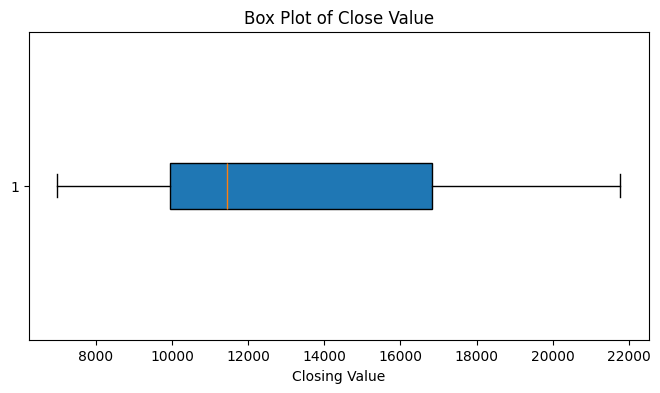

In [315]:
# checking if there are any outliers in the data using Box Plot

plt.figure(figsize=(8, 4))
plt.boxplot(df['Close'],patch_artist = True, vert = 0)
plt.title('Box Plot of Close Value')
plt.xlabel('Closing Value')
plt.show()


**Cleaning the dataset**:

Checking for missing dates and adding them back to the dataset.
Forwardfill the values from the previous rows. -- Currently, even if stock market is not open on Saturday and Sunday, still Friday closing will be the opening for Monday. So, assuming forward fill imputation would not be a problem.

In [316]:
start = df.index[0].date() # minimum date from the dataset
end = df.index[len(df)-1].date() # maximum date from the dataset
new_dates = pd.date_range(start=start,end=end,freq='D') # Generating new dates starting from minimum and extending till maximum

# Re-indexing new dates with the old dates

df = df.reindex(new_dates)
df = df.rename_axis('Fin_Dt')
df.reset_index(inplace=True)
df = df.ffill()

# Maintaining one date column as index and other date column for our reference.

df['Date'] = pd.to_datetime(df['Fin_Dt'])
df.set_index('Date', inplace=True)

df.head()

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr),Year,Month
Date,,,,,,,,,
2015-11-09,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17,2015.0,11.0
2015-11-10,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47,2015.0,11.0
2015-11-11,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,2015.0,11.0
2015-11-12,2015-11-12,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,2015.0,11.0
2015-11-13,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,2015.0,11.0


Cleaning the test dataset

In [317]:
# Check for missing dates and add them to the dataset
# Identify Start and End dates from the dataset and generate new dates from those dates which will be daily dates

start = df_test.index[0].date()
end = df_test.index[len(df_test)-1].date()
new_dates = pd.date_range(start=start,end=end,freq='D')

# Re-indexing new dates with the old dates

df_test = df_test.reindex(new_dates)
df_test = df_test.rename_axis('Fin_Dt')
df_test.reset_index(inplace=True)
df_test = df_test.ffill()

df_test['Date'] = pd.to_datetime(df_test['Fin_Dt'])
df_test.set_index('Date', inplace=True)

df_test.head()

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr)
Date,,,,,,,
2024-01-01,2024-01-01,21727.75,21834.35,21680.85,21741.90,153995217.0,14184.09
2024-01-02,2024-01-02,21751.35,21755.60,21555.65,21665.80,263711568.0,25316.13
2024-01-03,2024-01-03,21661.10,21677.00,21500.35,21517.35,311933117.0,32329.23
2024-01-04,2024-01-04,21605.80,21685.65,21564.55,21658.60,339172697.0,30868.15
2024-01-05,2024-01-05,21705.75,21749.60,21629.20,21710.80,309303266.0,26554.49


**Plot the Training & Test dataset**.

Graph is being plotted for the Close values as training and testing to be done for that column of the dataset.

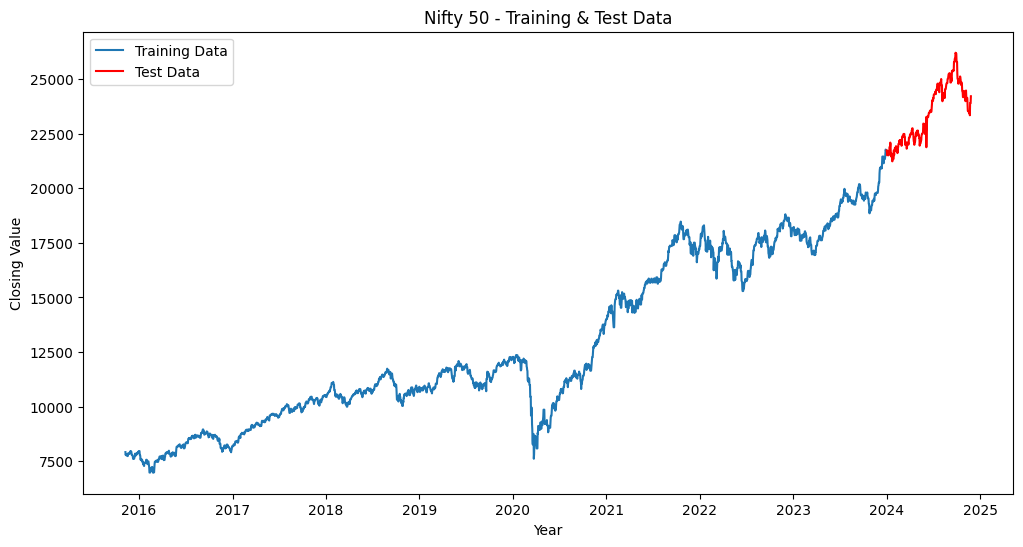

In [318]:
# Use the 'Close' prices as the target variable and plot the Original Data
final_data = df[['Fin_Dt','Close']] ## will be used at a later point in the code.

final_data_test = df_test[['Fin_Dt','Close']]

close_plot_test = final_data_test['Close']

plt.figure(figsize=(12, 6))
plt.plot(final_data['Close'], label='Training Data')
plt.plot(close_plot_test, color = 'red', label = 'Test Data')
plt.title("Nifty 50 - Training & Test Data")
plt.xlabel("Year")
plt.ylabel("Closing Value")
plt.legend()
plt.show()

**Stationarity Check**:

To check if the data is stationary, here we used **Augmented Dickey Fuller's Test** and **Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test**.
This test helps us understand if there is a change in the Mean with absolute time. But, it doesn't give any information on the variance of the timeseries.

The null hypothesis for the KPSS test is that the data are stationary. For this test, we do NOT want to reject the null hypothesis. In other words, we want the p-value to be greater than 0.05 not less than 0.05. Where as, for the ADF test, p-valeu has to be less than 0.05 for the time-series to be stationary.

In [319]:
# Perform the ADF test
adf_res = adfuller(df['Close'], autolag='AIC')

print(f"ADF Statistic: {adf_res[0]}")
print(f"p-value: {adf_res[1]}")
print(f"No Lags Used: {adf_res[2]}")
print(f"Number of observations used: {adf_res[3]}")
print(f"Critical Values: {adf_res[4]}")

if adf_res[1] <= 0.05:
    print("ADF Test - Reject the null hypothesis")
    print("ADF Test - The data is stationary")

else:
    print("ADF Test - The null hypothesis cannot be rejected")
    print("ADF Test - The data is not stationary")

print('\n')
# Perform the KPSS test

kpss_res = kpss(df['Close'], regression='c')

print(f"KPSS Statistic: {kpss_res[0]}")
print(f"p-value: {kpss_res[1]}")
print(f"No Lags Used: {kpss_res[2]}")
print(f"Critical Values: {kpss_res[3]}")

if kpss_res[1] <= 0.05:
    print("KPSS Test - Reject the null hypothesis")
    print("KPSS Test - The data is not stationary")

else:
    print("KPSS Test - The null hypothesis cannot be rejected")
    print("KPSS Test - The data is stationary")

ADF Statistic: 0.2840356873512916
p-value: 0.9766000806277764
No Lags Used: 13
Number of observations used: 2959
Critical Values: {'1%': -3.432561889805549, '5%': -2.862517267814074, '10%': -2.5672902261937134}
ADF Test - The null hypothesis cannot be rejected
ADF Test - The data is not stationary


KPSS Statistic: 8.20993281771301
p-value: 0.01
No Lags Used: 32
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS Test - Reject the null hypothesis
KPSS Test - The data is not stationary


**First Order Differencing**:

Since the p-value is greater than 0.05, we fail to reject the null hypothesis, which means the data is not stationary.

Lets do the first order differencing of the data to remove the varying Mean component. Below are the different ways that can be used to remove the varying mean and variance components.

**Differencing**: Subtracting the current observation from the previous one to achieve stationarity.
**Detrending**: Another technique for removing seasonality from time series data.
**Seasonal decomposition**: Decomposing the time series into seasonal, trend, and residual components.
**Log transformation**: Taking the natural logarithm of the data to stabilize variance.
**Log difference**: Combining log transformation and differencing to address both trend and seasonality.

In [320]:
# Seasonal adjustment
df['Seasonal_Adjusted'] = df['Close'].diff(periods=7).dropna() ## An integer that controls the number of periods over which the difference is calculated.

# Differencing
df['Differenced'] = df['Close'].diff().dropna()

# Log Differencing
df['Log_Differenced'] = np.log(df['Close']/df['Close'].shift(1)).dropna()

df.head(10)

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr),Year,Month,Seasonal_Adjusted,Differenced,Log_Differenced
Date,,,,,,,,,,,,
2015-11-09,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17,2015.0,11.0,NaN,NaN,NaN
2015-11-10,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47,2015.0,11.0,NaN,-131.85,-0.016798
2015-11-11,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,2015.0,11.0,NaN,41.65,0.005337
2015-11-12,2015-11-12,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,2015.0,11.0,NaN,0.00,0.000000
2015-11-13,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,2015.0,11.0,NaN,-62.75,-0.008051
2015-11-14,2015-11-14,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,2015.0,11.0,NaN,0.00,0.000000
2015-11-15,2015-11-15,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,2015.0,11.0,NaN,0.00,0.000000
2015-11-16,2015-11-16,7732.95,7838.85,7714.15,7806.60,154134885.0,6871.15,2015.0,11.0,-108.6,44.35,0.005697
2015-11-17,2015-11-17,7848.75,7860.45,7793.00,7837.55,149451211.0,6367.14,2015.0,11.0,54.2,30.95,0.003957


**Plot the data**

Validate the difference between actual, differenced, seasonal, and log differenced data.

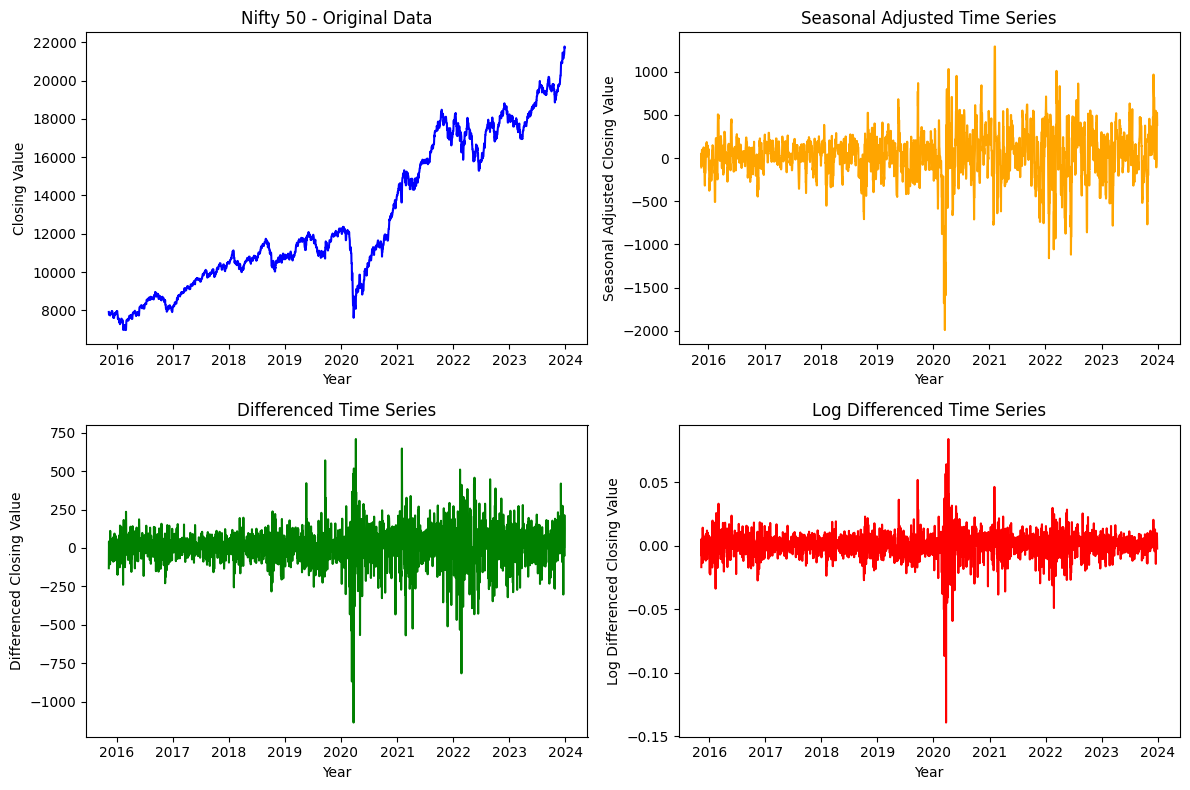

In [321]:
# Visualize the results
plt.figure(figsize=(12, 8))

# Original time series
plt.subplot(2, 2, 1)
plt.plot(final_data['Close'], color = 'blue')
plt.title('Nifty 50 - Original Data')
plt.xlabel('Year')
plt.ylabel('Closing Value')

# Seasonal Adjusted
plt.subplot(2, 2, 2)
plt.plot(df['Seasonal_Adjusted'], color = 'orange')
plt.title('Seasonal Adjusted Time Series')
plt.xlabel('Year')
plt.ylabel('Seasonal Adjusted Closing Value')

# Differenced
plt.subplot(2, 2, 3)
plt.plot(df['Differenced'], color = 'green')
plt.title('Differenced Time Series')
plt.xlabel('Year')
plt.ylabel('Differenced Closing Value')

# Log Differenced
plt.subplot(2, 2, 4)
plt.plot(df['Log_Differenced'], color = 'red')
plt.title('Log Differenced Time Series')
plt.xlabel('Year')
plt.ylabel('Log Differenced Closing Value')

plt.tight_layout()
plt.show()

**Interpretation of HeatMap**:

1. Seasonal Patterns
2. Increasing Trend Over Time
3. Anomalies and Deviations: 2020 shows an anamoly in both the Heat Maps

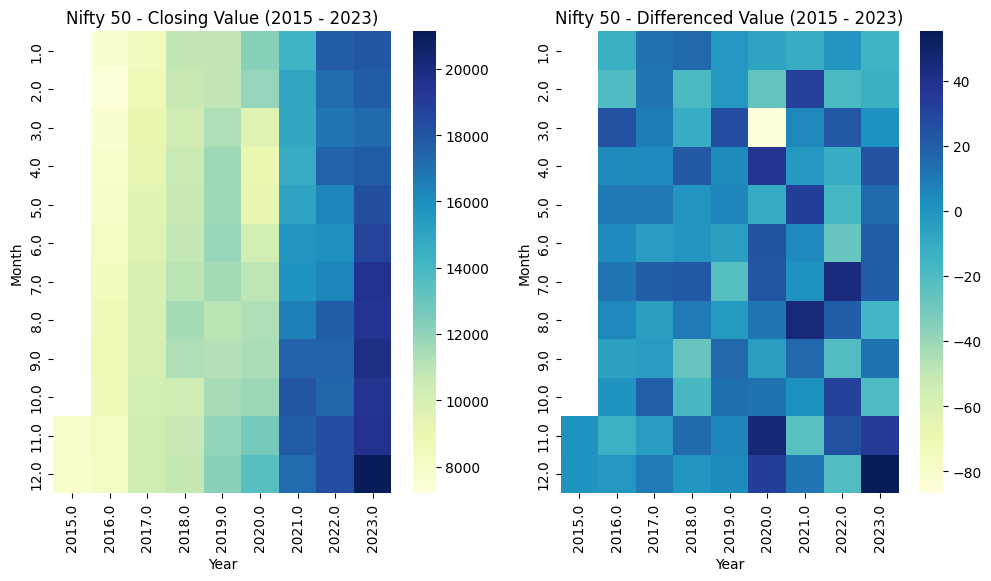

In [322]:
pivot_date = df[['Year','Month','Close']]
pivot_diff = df[['Year','Month','Differenced']]
pivot_log = df[['Year','Month','Log_Differenced']]

df_pivot = pivot_date.pivot_table(index="Month", columns='Year', values='Close', aggfunc='mean')
df_diff_pivot = pivot_diff.pivot_table(index="Month", columns='Year', values='Differenced', aggfunc='mean')

df_log_pivot = pivot_log.pivot_table(index="Month", columns='Year', values='Log_Differenced', aggfunc='mean')

# df_pivot.head()

plt.figure(figsize=(12, 6))

# Plotting the heatmap
plt.subplot(1,2,1)
sns.heatmap(df_pivot, cmap='YlGnBu', annot=False)
plt.title("Nifty 50 - Closing Value (2015 - 2023)")

plt.subplot(1,2,2)
sns.heatmap(df_diff_pivot, cmap='YlGnBu', annot=False)
plt.title("Nifty 50 - Differenced Value (2015 - 2023)")
plt.show()


**Stationary check post differencing**.

The differenced data has approximately more or less constant mean when we apply windows.

But, lets calculate the ADF value again to re-confirm

In [323]:
# Perform the ADF test

adf_res_mod = adfuller(df['Differenced'].dropna(), autolag='AIC')
print(f"ADF Statistic: {adf_res_mod[0]}")
print(f"p-value: {adf_res_mod[1]}")
print(f"#Lags Used: {adf_res_mod[2]}")
print(f"Number of Observations Used: {adf_res_mod[3]}")
print(f"Critical Values: {adf_res_mod[4]}")

if adf_res_mod[1] <= 0.05:
    print("ADF Test - Reject the null hypothesis")
    print("ADF Test - The data is stationary")

else:
    print("ADF Test - The null hypothesis cannot be rejected")
    print("ADF Test - The data is not stationary")

print('\n')
# Perform the KPSS test

kpss_res = kpss(df['Differenced'].dropna(), regression='c')

print(f"KPSS Statistic: {kpss_res[0]}")
print(f"p-value: {kpss_res[1]}")
print(f"No Lags Used: {kpss_res[2]}")
print(f"Critical Values: {kpss_res[3]}")

if kpss_res[1] <= 0.05:
    print("KPSS Test - Reject the null hypothesis")
    print("KPSS Test - The data is not stationary")

else:
    print("KPSS Test - The null hypothesis cannot be rejected")
    print("KPSS Test - The data is stationary")

ADF Statistic: -13.895226266266175
p-value: 5.868297702786577e-26
#Lags Used: 12
Number of Observations Used: 2959
Critical Values: {'1%': -3.432561889805549, '5%': -2.862517267814074, '10%': -2.5672902261937134}
ADF Test - Reject the null hypothesis
ADF Test - The data is stationary


KPSS Statistic: 0.17804955434536518
p-value: 0.1
No Lags Used: 1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
KPSS Test - The null hypothesis cannot be rejected
KPSS Test - The data is stationary


The p-value obtained is less than the significance level of 0.05, and the ADF statistic is less than any of the critical values.
we reject the Null hypothesis in favor of the alternative. So, the time series is, in fact, stationary

**Histogram** representation of actual data and its differenced form.
Differenced data is approximately following Guassian Distribution

Variance plot as well for the differenced and log differenced data. Is the differenced data stationary? Though the differenced data follows Gaussian distribution, we see changes in the variance plot.


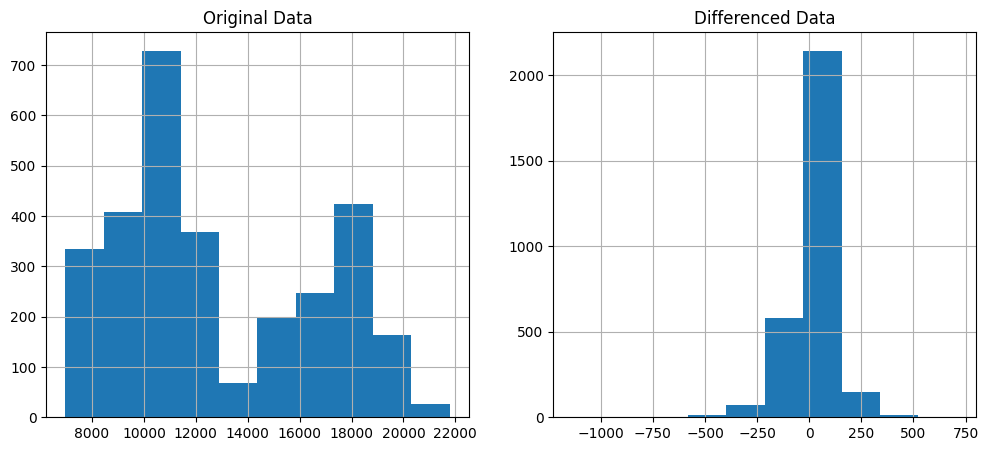

In [324]:
plt.figure(figsize=(12, 5))

## Histogram of the Original data

plt.subplot(1,2,1)
final_data['Close'].dropna().hist()
plt.title("Original Data")

## Histogram of the Differenced data

plt.subplot(1,2,2)
df['Differenced'].dropna().hist()
plt.title("Differenced Data")
plt.show()


Text(0.5, 1.0, 'Rolling Standard Deviation Plot')

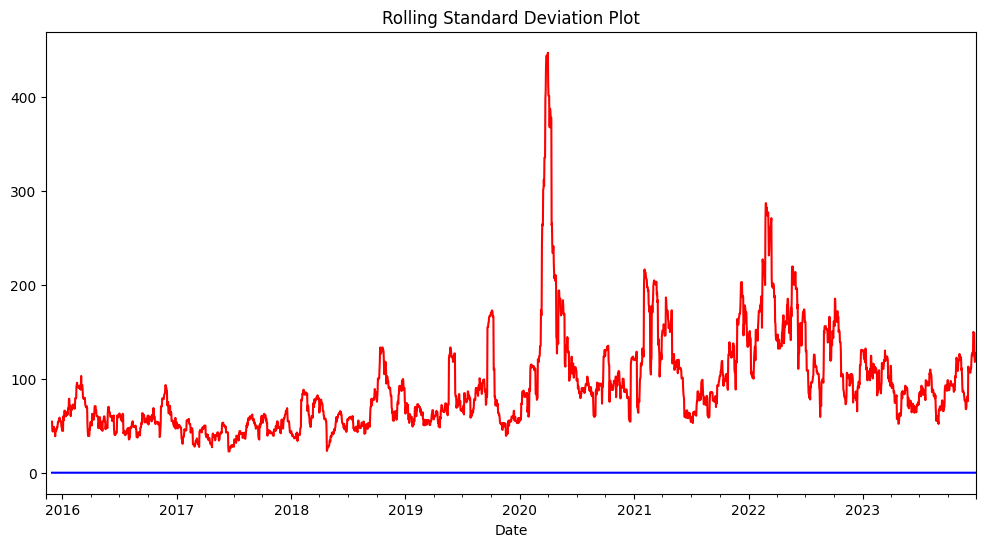

In [325]:
## Now lets check how is the variance. Is the differenced data stationary or not
plt.figure(figsize=(12, 6))
# add the 20 day rolling standard deviation:
df['Differenced'].dropna().rolling(window=20).std().plot(style='r')
df['Log_Differenced'].dropna().rolling(window=20).std().plot(style='b')
# So the Variance changing over time.
plt.xlabel("Date")
plt.title("Rolling Standard Deviation Plot")

**ACF and PACF** Plots

Lets check ACF and PACF details of the differenced data for 20 lags

<Figure size 1200x600 with 0 Axes>

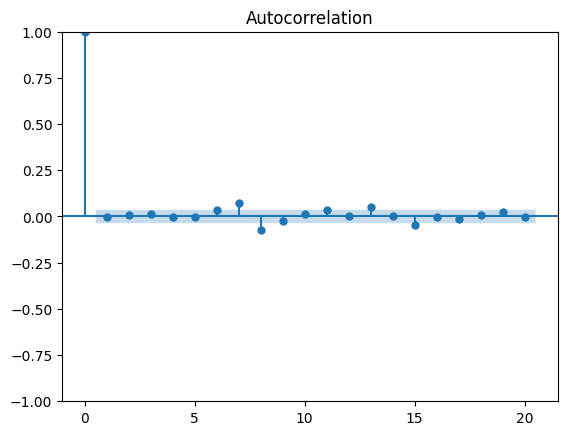

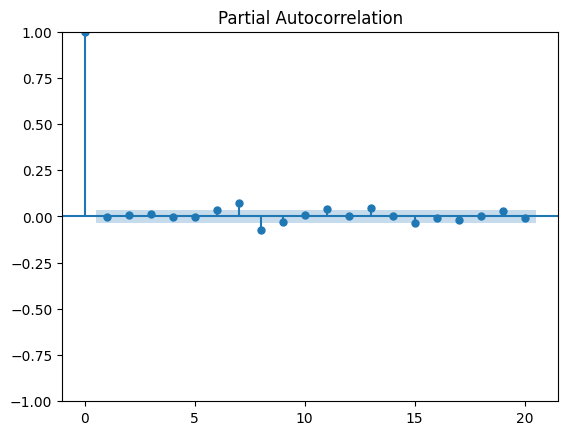

In [326]:
# ACF and PACF of the differenced series
plt.figure(figsize=(12, 6))

plot_acf(df['Differenced'].dropna(), lags=20)

plot_pacf(df['Differenced'].dropna(), lags=20)
plt.show()

**Based on the ACF and PACF plots, it shows complete white noise which need to be modelled.**

Let's check the PSD of the data to understand the frequency domain details of its respective time domain.

**Power Spectral Density** - **Welch Method** using **Hann** window.


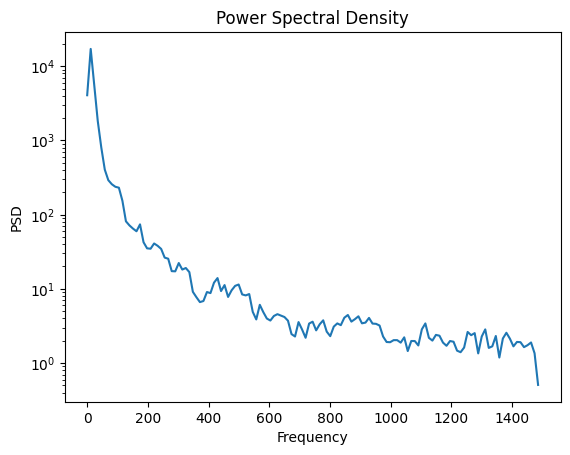

In [327]:
# PSD of the Differenced timeseries
f,PSD = signal.welch(df['Close'],fs=len(df['Differenced'].dropna()), window='hann')
plt.semilogy(f,PSD)
plt.title("Power Spectral Density")
plt.xlabel("Frequency")
plt.ylabel("PSD")
plt.show()

# PSD shows varying frequency details



Get the train and test datasets

In [328]:
# split into train and test sets
X = df['Close'].dropna().values
Y = df_test['Close'].dropna().values
train, test = X, Y

**Random walk with drift**

The ACF and PACF happens to show pure white noise.

If after differencing your time series, both the ACF and PACF plots indicate only white noise, then the most likely model to identify is a simple ARIMA(0,1,0) model, which essentially represents a "random walk with drift" where the only significant component is the first difference of the data, meaning the change between consecutive observations is essentially random noise

ARIMA(0,1,0):
"0" for AR: No autoregressive component (no dependence on past values).
"1" for I: One order of differencing is required to achieve stationarity.
"0" for MA: No moving average component.

In [329]:
# Fit ARMA(0,1,0) model
model = ARIMA(df['Close'].dropna(), order=(0,1,0), freq = "D")
fitted_model = model.fit()
print(fitted_model.summary())
step = len(df_test['Close'].dropna())

# Forecast next length of the test data steps
forecast = fitted_model.get_forecast(steps=step)
forecast_summary = forecast.summary_frame()

residuals = pd.DataFrame(fitted_model.resid, columns=["Values"])
# summary stats of residuals
print(residuals.describe())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2973
Model:                 ARIMA(0, 1, 0)   Log Likelihood              -18072.827
Date:                Sun, 29 Dec 2024   AIC                          36147.655
Time:                        14:59:27   BIC                          36153.652
Sample:                    11-09-2015   HQIC                         36149.813
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.12e+04    107.483    104.221      0.000     1.1e+04    1.14e+04
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             20769.64
Prob(Q):                              0.84   Pr

**Plot** the Forecasted data along with the Train and Test data

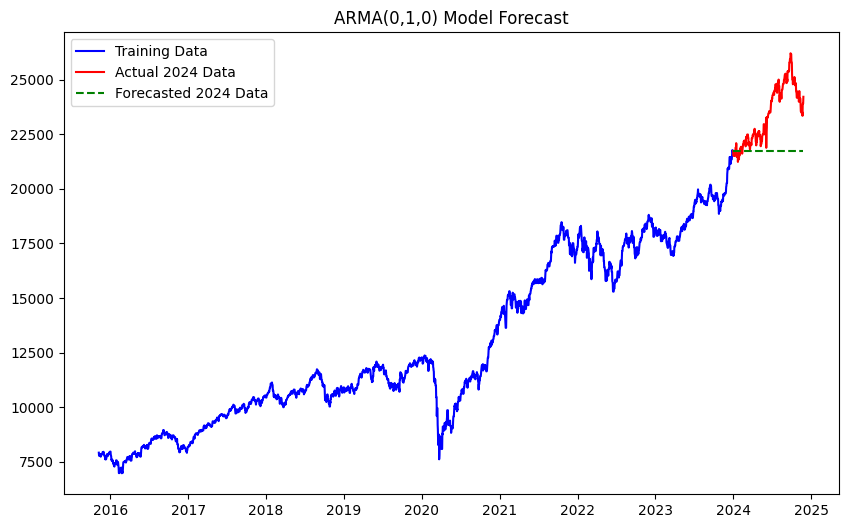

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr),Year,Month,Seasonal_Adjusted,Differenced,Log_Differenced
Date,,,,,,,,,,,,
2015-11-09,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17,2015.0,11.0,NaN,NaN,NaN
2015-11-10,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47,2015.0,11.0,NaN,-131.85,-0.016798
2015-11-11,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,2015.0,11.0,NaN,41.65,0.005337
2015-11-12,2015-11-12,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,2015.0,11.0,NaN,0.00,0.000000
2015-11-13,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,2015.0,11.0,NaN,-62.75,-0.008051


In [330]:
forecast_vals = fitted_model.forecast(steps=step)

# Set forecast index to a date range for 2024
forecast_summary.index = pd.date_range(start='2024-01-01', periods=step, freq='D')

# Plot the forecasted values against the actual test data

plt.figure(figsize=(10,6))
plt.plot(df['Close'].dropna().index, df['Close'], label='Training Data', color='blue')
plt.plot(df_test['Close'].index, df_test['Close'], label='Actual 2024 Data', color='red')
plt.plot(forecast_summary.index, forecast_vals, label='Forecasted 2024 Data', color='green', linestyle='--')

#plt.plot(np.arange(len(df['Close']), len(df['Close']) + 300), forecast.predicted_mean, label="Forecast", color='orange')

plt.title("ARMA(0,1,0) Model Forecast")
plt.legend()
plt.show()

df.head()

**Plot** the Residuals of Random Walk with Drift

One of the most important steps in ARIMA modeling is to check if the residual series that is generated is **stationary**. Residuals are the difference between observed values and those produced by a model. It help us to determine whether a linear model is appropriate in modeling the given data

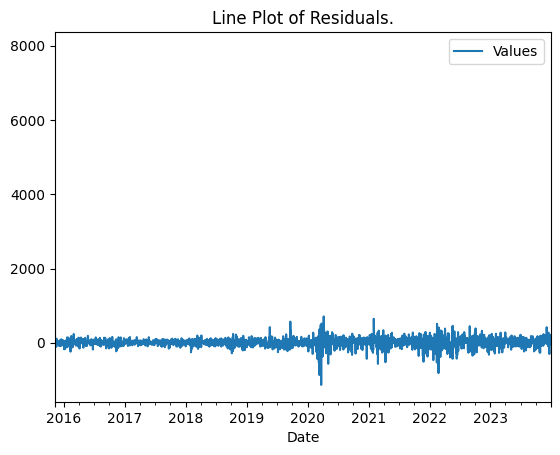

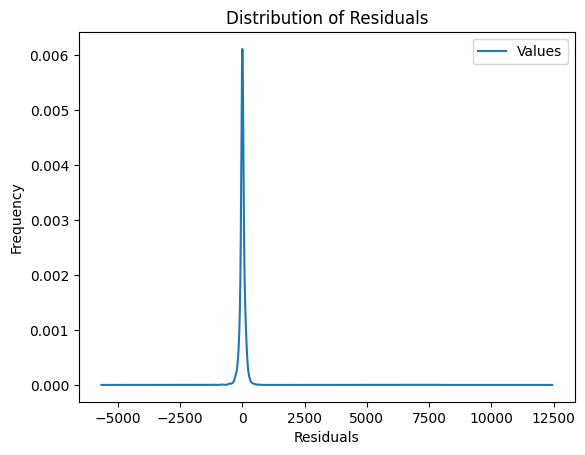

Runs test: zstat = -3.893895066289675, p-value = 9.864733553790103e-05


In [331]:
# line plot of residuals
residuals.plot()
plt.title("Line Plot of Residuals.")

# density plot of residuals
residuals.plot(kind='kde')
plt.title("Density Plot of Residuals.")
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Perform a runs test for randomness
zstat, pval = runstest_1samp(residuals)
print(f'Runs test: zstat = {zstat}, p-value = {pval}')

Checking **MAE, RMSE, R^2, and MAPE**

In [332]:
# Evaluate the model using error metrics
# Ensure both series have the same length and index before calculating R^2

# Reset index of df_test['Close'] to match forecast_vals index
y_true = df_test['Close'].dropna().reset_index(drop=True)
y_pred = pd.Series(forecast_vals).reset_index(drop=True)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R^2 using the aligned series
r2 = r2_score(y_true, y_pred)
print(f'R-squared (R^2): {r2}')

# Calculate MAPE
masked_actual = np.ma.masked_array(y_true, mask=y_true==0) #Mask values where y_true is 0 to avoid division by zero.
MAPE = (np.fabs(masked_actual.filled(0) - y_pred.to_numpy())/masked_actual.filled(1)).mean() #Convert masked_actual and y_pred to NumPy arrays for compatibility.

print(f'MAPE: {MAPE}')

Mean Absolute Error (MAE): 1694.6612121212108
Root Mean Squared Error (RMSE): 2122.564876133103
R-squared (R^2): -1.6056442678492626
MAPE: 0.06962344222485164


Lets choose an appropriate model by identifying **AIC values** for a set of models that include variations of **AR, MA, ARMA, and ARIMA**

Checking AIC Values for various models. Since auto_arima is ignoring a few models, we are manually geenrating AIC for sample models.

In [333]:
# Suppress warnings
warnings.filterwarnings("ignore") # Suppress all warnings

# Create a list to store the models and their AIC values
models = []

# Iterate through p, d, and q values up to the specified limits
for p in range(4):  # Iterate up to p=3
    for d in range(3): # Iterate up to d=2
        for q in range(4): # Iterate up to q=3
            try:
                model = ARIMA(df['Close'].dropna(), order=(p,d,q))
                results = model.fit()
                models.append((p, d, q, results.aic))
                print(f"ARIMA({p},{d},{q}): AIC={results.aic}") # Print the result of each iteration
            except Exception as e:
                print(f"Error fitting ARIMA({p},{d},{q}): {e}") # print the exception if there is one

# Find the model with the lowest AIC
best_model = min(models, key=lambda x: x[3])

print(f"Best Model: ARIMA({best_model[0]},{best_model[1]},{best_model[2]}) with AIC={best_model[3]}")


ARIMA(0,0,0): AIC=78275.87141754924
ARIMA(0,0,1): AIC=53449.45457250668
ARIMA(0,0,2): AIC=50085.88744956731
ARIMA(0,0,3): AIC=48563.69852206959
ARIMA(0,1,0): AIC=36147.65493061466
ARIMA(0,1,1): AIC=36149.64124635637
ARIMA(0,1,2): AIC=36151.47756024068
ARIMA(0,1,3): AIC=36152.6014664648
ARIMA(0,2,0): AIC=38200.45421091947
ARIMA(0,2,1): AIC=36139.45827182513
ARIMA(0,2,2): AIC=36141.23878367242
ARIMA(0,2,3): AIC=36143.13182343519
ARIMA(1,0,0): AIC=36172.21832359528
ARIMA(1,0,1): AIC=36173.942967225514
ARIMA(1,0,2): AIC=36175.77743591025
ARIMA(1,0,3): AIC=36176.88410734055
ARIMA(1,1,0): AIC=36149.64045066121
ARIMA(1,1,1): AIC=36151.640762208874
ARIMA(1,1,2): AIC=36153.233602628534
ARIMA(1,1,3): AIC=36154.59508126742
ARIMA(1,2,0): AIC=37329.119582075204
ARIMA(1,2,1): AIC=36141.24042694962
ARIMA(1,2,2): AIC=36137.73064053982
ARIMA(1,2,3): AIC=36145.012810985376
ARIMA(2,0,0): AIC=36173.94284683875
ARIMA(2,0,1): AIC=36170.330929319025
ARIMA(2,0,2): AIC=36172.055402863494
ARIMA(2,0,3): AIC=3617

**ARIMA Modelling**:

As observed AIC value is less for ARIMA Order (ignoring seasonality) -  (1 2 2) - 36137.73064054128.
So lets try to fit 1,2,2 and check the output.

In [334]:
# Forecast next steps based on the length of the forecast
train_data = df['Close'].dropna()
test_data = df_test['Close']
forecast_steps = len(test_data)

model = ARIMA(train_data, order=(best_model[0],best_model[1],best_model[2]),freq="D")
fitted_model = model.fit()
forecast = fitted_model.get_forecast(steps=forecast_steps,freq="D")
forecast_summary = forecast.summary_frame()

print(fitted_model.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2973
Model:                 ARIMA(1, 2, 2)   Log Likelihood              -18064.865
Date:                Sun, 29 Dec 2024   AIC                          36137.731
Time:                        15:02:00   BIC                          36161.717
Sample:                    11-09-2015   HQIC                         36146.363
                         - 12-29-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9732      0.016    -59.788      0.000      -1.005      -0.941
ma.L1         -0.0167      0.016     -1.076      0.282      -0.047       0.014
ma.L2         -0.9830      0.015    -66.463      0.0

**Plot** the Results

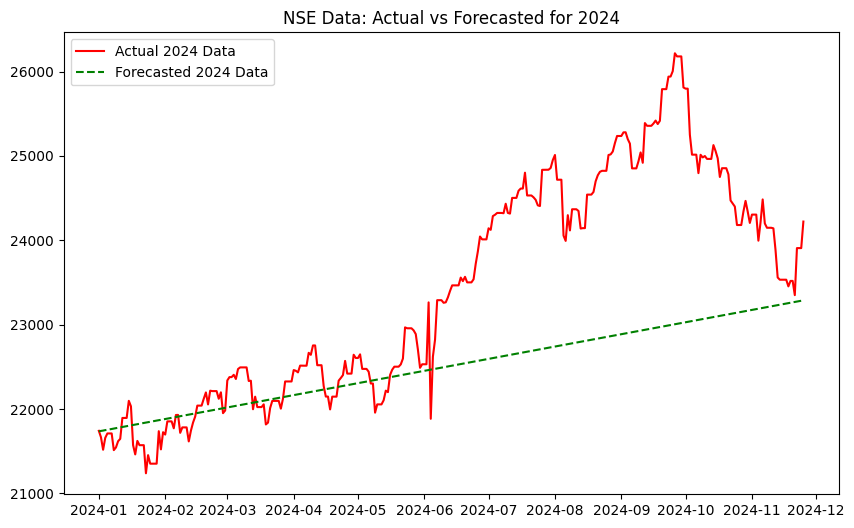

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr),Year,Month,Seasonal_Adjusted,Differenced,Log_Differenced
Date,,,,,,,,,,,,
2015-11-09,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17,2015.0,11.0,NaN,NaN,NaN
2015-11-10,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47,2015.0,11.0,NaN,-131.85,-0.016798
2015-11-11,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,2015.0,11.0,NaN,41.65,0.005337
2015-11-12,2015-11-12,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,2015.0,11.0,NaN,0.00,0.000000
2015-11-13,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,2015.0,11.0,NaN,-62.75,-0.008051


In [335]:
forecast_vals = fitted_model.forecast(steps=forecast_steps)

# Set forecast index to a date range for 2024
forecast_summary.index = pd.date_range(start='2024-01-01', periods=forecast_steps, freq='D')

# Plot the forecasted values against the actual test data

plt.figure(figsize=(10,6))
# plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual 2024 Data', color='red')
plt.plot(forecast_summary.index, forecast_vals, label='Forecasted 2024 Data', color='green', linestyle='--')
plt.title('NSE Data: Actual vs Forecasted for 2024')
plt.legend()
plt.show()

df.head()

**Residual Plot**

In [336]:
arima_residuals = pd.DataFrame(fitted_model.resid, columns=["Values"])
# summary stats of residuals
print(arima_residuals.describe())


            Values
count  2973.000000
mean      3.236693
std     194.600205
min   -4090.148715
25%     -22.207941
50%      -1.566506
75%      38.081090
max    7915.200000


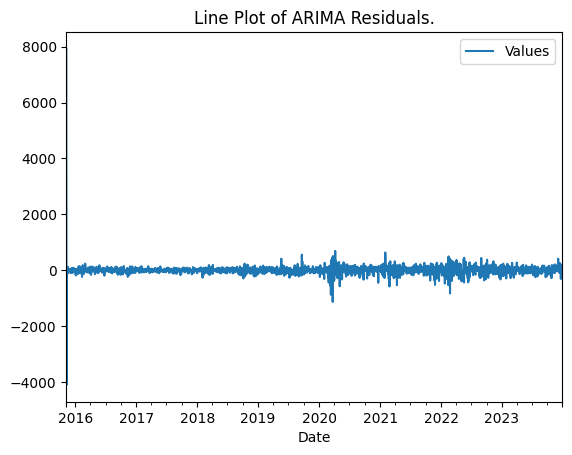

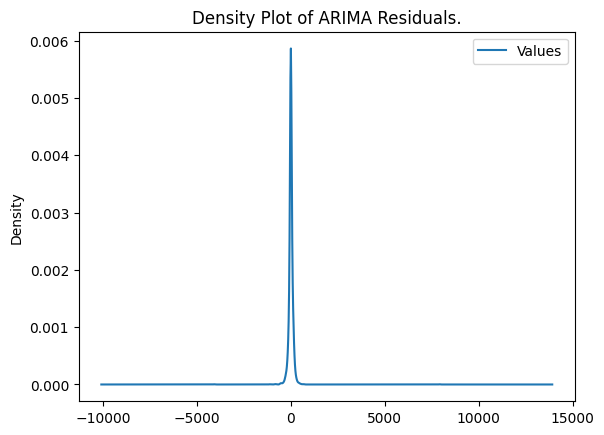

In [337]:

# line plot of residuals
arima_residuals.plot()
plt.title("Line Plot of ARIMA Residuals.")

# density plot of residuals
arima_residuals.plot(kind='kde')
plt.title("Density Plot of ARIMA Residuals.")
plt.show()

**MAE, RMSE, R^2 and MAPE**

In [338]:
# Evaluate the model using error metrics
# Ensure both series have the same length and index before calculating R^2

# Reset index of df_test['Close'] to match forecast_vals index
y_true = df_test['Close'].dropna().reset_index(drop=True)
y_pred = pd.Series(forecast_vals).reset_index(drop=True)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R^2 using the aligned series

r2 = r2_score(y_true, y_pred)
print(f'R-squared (R^2): {r2}')

# Calculate MAPE
masked_actual = np.ma.masked_array(y_true, mask=y_true==0) #Mask values where y_true is 0 to avoid division by zero.
MAPE = (np.fabs(masked_actual.filled(0) - y_pred.to_numpy())/masked_actual.filled(1)).mean() #Convert masked_actual and y_pred to NumPy arrays for compatibility.

print(f'MAPE: {MAPE}')

Mean Absolute Error (MAE): 963.431497088524
Root Mean Squared Error (RMSE): 1298.4844777642281
R-squared (R^2): 0.02486060482575192
MAPE: 0.03936266936963969


Trying **SARIMAX** -
As the ARIMA has forecasted the trend accurately but the seasonality component is missing, checking the minimum AIC value for various model orders and seasonal orders.

In [339]:
model = pm.auto_arima(train_data, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=7,              # frequency of series (weekly)
                      d=2,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0,
                      D=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[7]             : AIC=inf, Time=6.81 sec
 ARIMA(0,2,0)(0,1,0)[7]             : AIC=39886.362, Time=0.18 sec
 ARIMA(1,2,0)(1,1,0)[7]             : AIC=38349.184, Time=2.14 sec
 ARIMA(0,2,1)(0,1,1)[7]             : AIC=inf, Time=4.64 sec
 ARIMA(1,2,0)(0,1,0)[7]             : AIC=39021.667, Time=0.16 sec
 ARIMA(1,2,0)(2,1,0)[7]             : AIC=38058.228, Time=2.39 sec
 ARIMA(1,2,0)(2,1,1)[7]             : AIC=inf, Time=11.12 sec
 ARIMA(1,2,0)(1,1,1)[7]             : AIC=inf, Time=4.12 sec
 ARIMA(0,2,0)(2,1,0)[7]             : AIC=38898.287, Time=0.94 sec
 ARIMA(2,2,0)(2,1,0)[7]             : AIC=37698.595, Time=5.27 sec
 ARIMA(2,2,0)(1,1,0)[7]             : AIC=38005.128, Time=2.47 sec
 ARIMA(2,2,0)(2,1,1)[7]             : AIC=inf, Time=12.86 sec
 ARIMA(2,2,0)(1,1,1)[7]             : AIC=inf, Time=6.01 sec
 ARIMA(3,2,0)(2,1,0)[7]             : AIC=37527.698, Time=3.81 sec
 ARIMA(3,2,0)(1,1,0)[7]             : AIC=37849.171, 

Per Auto ARIMA ***among the given set of models***, with seasonality, the best model reported was **SARIMAX(3,2,0)(2,1,0)[7]**
Let's try to model the data using this order and seasonality.

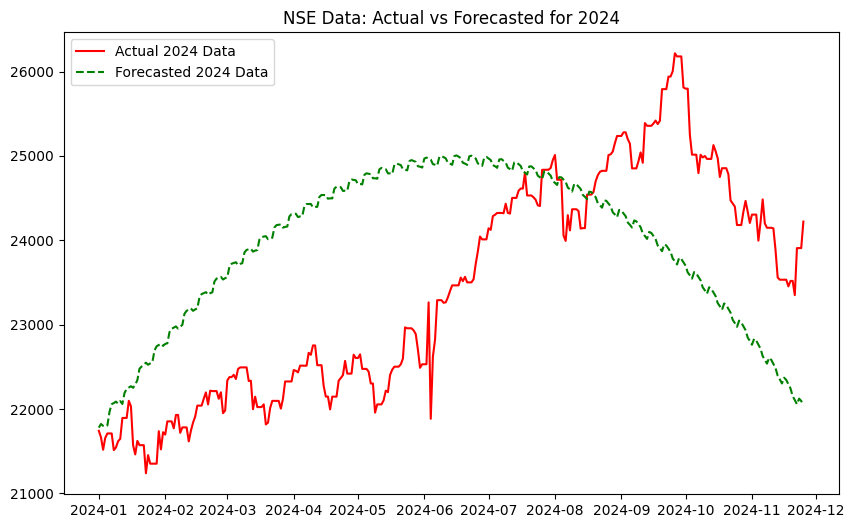

,Fin_Dt,Open,High,Low,Close,Shares Traded,Turnover (? Cr),Year,Month,Seasonal_Adjusted,Differenced,Log_Differenced
Date,,,,,,,,,,,,
2015-11-09,2015-11-09,7788.25,7937.75,7771.70,7915.20,218422388.0,9376.17,2015.0,11.0,NaN,NaN,NaN
2015-11-10,2015-11-10,7877.60,7885.10,7772.85,7783.35,170267413.0,7153.47,2015.0,11.0,NaN,-131.85,-0.016798
2015-11-11,2015-11-11,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,2015.0,11.0,NaN,41.65,0.005337
2015-11-12,2015-11-12,7838.80,7847.95,7819.10,7825.00,22380435.0,1123.44,2015.0,11.0,NaN,0.00,0.000000
2015-11-13,2015-11-13,7762.45,7775.10,7730.90,7762.25,165876819.0,7731.55,2015.0,11.0,NaN,-62.75,-0.008051


In [340]:
seasonal_order = (2, 1, 0, 7)  # (seasonality for daily data)
model = SARIMAX(df['Close'].dropna(), order=(3, 2, 0), seasonal_order=seasonal_order)
model_fit = model.fit()

# Forecast the data for 2024 (forecasting steps = length of test data)
forecast_steps = len(df_test['Close'].dropna())
forecast_Values = model_fit.forecast(steps=forecast_steps)

# Plot the forecasted values against the actual test data

plt.figure(figsize=(10,6))
#plt.plot(df.index, train_data, label='Training Data', color='blue')
plt.plot(df_test.index, test_data, label='Actual 2024 Data', color='red')
plt.plot(forecast_summary.index, forecast_Values, label='Forecasted 2024 Data', color='green', linestyle='--')
plt.title('NSE Data: Actual vs Forecasted for 2024')
plt.legend()
plt.show()

df.head()

**Residual Plot**

In [341]:
sarima_residuals = pd.DataFrame(model_fit.resid, columns=["Values"])
# summary stats of residuals
print(sarima_residuals.describe())

            Values
count  2973.000000
mean      1.253041
std     229.093615
min   -5389.824890
25%     -61.641741
50%      -0.818236
75%      60.733647
max    7915.200000


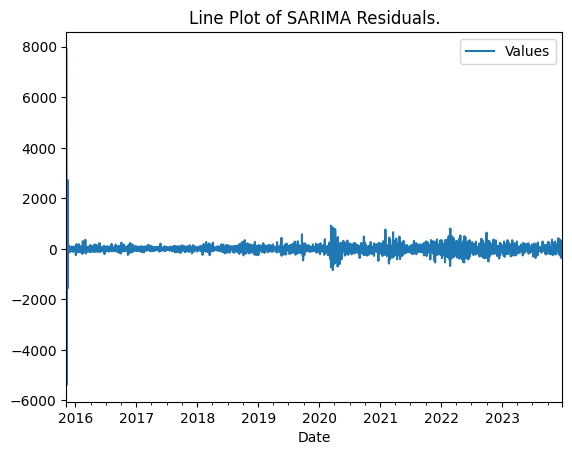

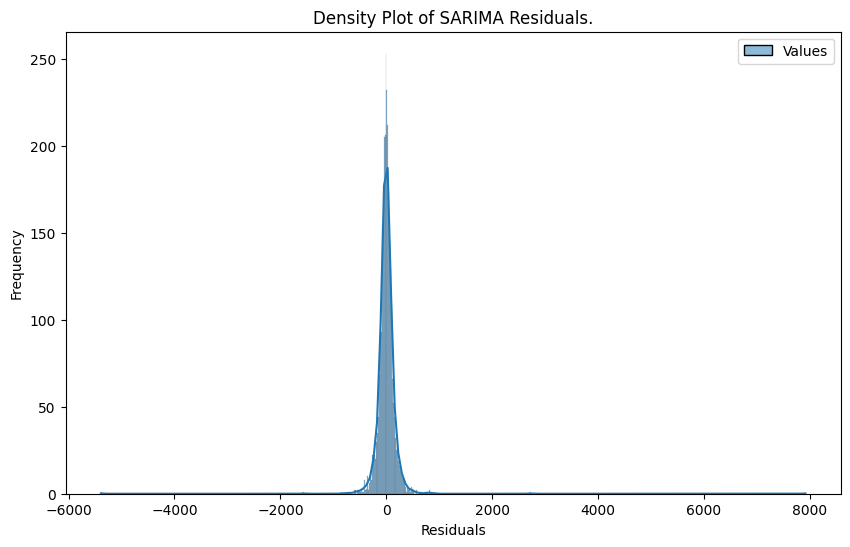

In [342]:
# line plot of residuals
sarima_residuals.plot()
plt.title("Line Plot of SARIMA Residuals.")

plt.figure(figsize=(10, 6))
sns.histplot(sarima_residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title("Density Plot of SARIMA Residuals.")
plt.show()

**MAE, RMSE, R^2, MAPE**

In [343]:
# Evaluate the model using error metrics
# Ensure both series have the same length and index before calculating R^2

# Reset index of df_test['Close'] to match forecast_vals index
y_true = df_test['Close'].dropna().reset_index(drop=True)
y_pred = pd.Series(forecast_vals).reset_index(drop=True)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R^2 using the aligned series

r2 = r2_score(y_true, y_pred)
print(f'R-squared (R^2): {r2}')

# Calculate MAPE
masked_actual = np.ma.masked_array(y_true, mask=y_true==0) #Mask values where y_true is 0 to avoid division by zero.
MAPE = (np.fabs(masked_actual.filled(0) - y_pred.to_numpy())/masked_actual.filled(1)).mean() #Convert masked_actual and y_pred to NumPy arrays for compatibility.

print(f'MAPE: {MAPE}')

Mean Absolute Error (MAE): 963.431497088524
Root Mean Squared Error (RMSE): 1298.4844777642281
R-squared (R^2): 0.02486060482575192
MAPE: 0.03936266936963969


Let's try **Rolling ARIMA** with a window size of 7 for best fit ARIMA of Order 1,2,2

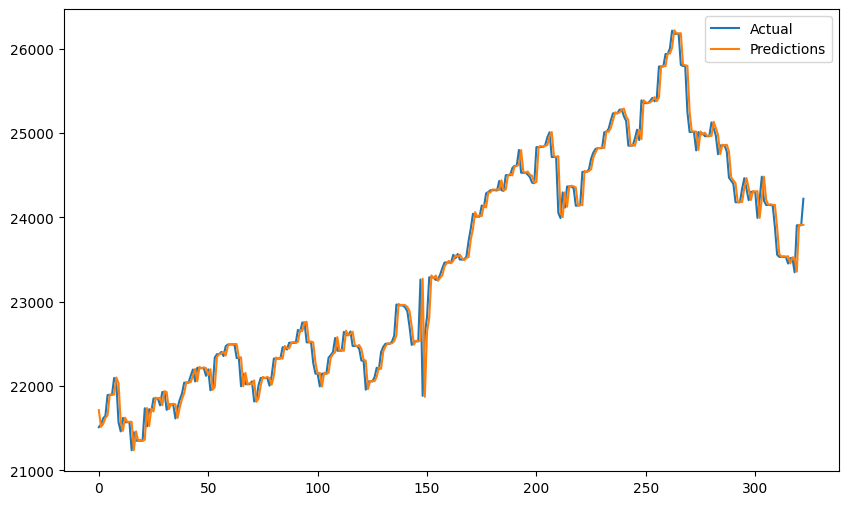

In [344]:
def rolling_arima_forecast(train_data, test_data, order=(1, 2, 2), window_size=7):
    """
    Performs rolling ARIMA forecast.

    Args:
        train_data: Training time series data.
        test_data: Test time series data.
        order: ARIMA model order (p, d, q).
        window_size: Rolling window size.

    Returns:
        Predictions, and actual values
    """

    predictions = []
    actual_values = []

    for i in range(window_size, len(test_data)):
    # Concatenates the window size of the test data to the train data until the end of test data for every iteration
        rolling_train = pd.concat([train_data, test_data[:i]])
        # Normal ARIMA model just that your train data varies for every loop
        model = ARIMA(rolling_train, order=order)
        model_fit = model.fit()
        prediction = model_fit.forecast(steps=1).iloc[0]
        predictions.append(prediction)
        actual_values.append(test_data.iloc[i])  # The actual closing price at the current index

    return predictions, actual_values

predictions, actual_values = rolling_arima_forecast(df['Close'], df_test['Close'])
residuals = np.array(actual_values) - np.array(predictions)

plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()

**Plotting** the Residuals

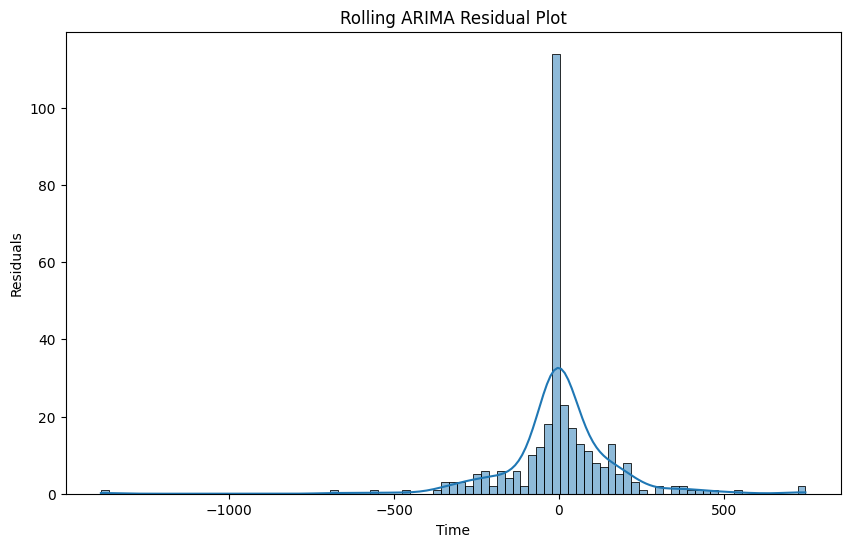

In [345]:

# Create the residual plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
# plt.scatter(df_test['Close'].index[7:], residuals)  # Plot residuals vs. time
# plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Rolling ARIMA Residual Plot')
plt.show()

**MAE, RMSE, R^2, MAPE**

In [346]:
mae = mean_absolute_error(actual_values, predictions)
rmse = np.sqrt(mean_squared_error(actual_values, predictions))
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

r2 = r2_score(actual_values, predictions)
print(f'R-squared (R^2): {r2}')

# Calculate MAPE
masked_actual = np.ma.masked_array(actual_values, mask=actual_values==0) #Mask values where y_true is 0 to avoid division by zero.
MAPE = (np.fabs(masked_actual.filled(0) - predictions)/masked_actual.filled(1)).mean() # predictions is already a numpy array. Removing .to_numpy()

print(f'MAPE: {MAPE}')

Mean Absolute Error (MAE): 96.91615837057557
Root Mean Squared Error (RMSE): 172.88049237089882
R-squared (R^2): 0.9824253839711821
MAPE: 0.004162968711080612


**Why Non-Linear model??**

Though we differenced the data and ensured that the process is stationary, as we have seen that there is still varying component of the Variance with absolute time. This indicates **Heteroscedasticity**. So, lets try Non-linear model to fit the data.

**LSTM** Long Short-Term Memory (LSTM) model, a type of recurrent neural network well-suited for time series data

We are using a sequential model which is a linear stack of layers. Two LSTM layers are added to the model with 50 units of LSTM in each layer. A Dense layer with one unit is added as the output layer, producing the predicted stock price.

The model is compiled with the **adam** optimizer (Adaptive Moment Estimation) and mean_squared_error as the loss function (Best Estimator of mean).

In [347]:
train_data = df['Close']
test_data = df_test['Close']

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), 0])
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 60

X_train, y_train = create_dataset(train_scaled, look_back)
X_test, y_test = create_dataset(test_scaled, look_back)

# Shaping the datasets
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

#Sequential Model with 2 layers on top of it
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predictions and re-scaling
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)

## Invert scaling for predictions and actual values to get them back to the original scale
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

#same length as the actual test data
forecasted_prices = predictions_rescaled.flatten()
actual_prices = y_test_rescaled.flatten()

# Align with the test data (forecasted_prices will have one less value than the test data)

forecasted_prices = forecasted_prices[:len(test_data) - look_back]

model.summary()

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0419
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 3.2914e-04
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 3.0431e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 3.0707e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 3.0225e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 3.0383e-04
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 2.8636e-04
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 2.6416e-04
Epoch 9/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 2.5686e-04
Epoch 10/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 2.4210e-04
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

**Plot** the Test Data and predicted data

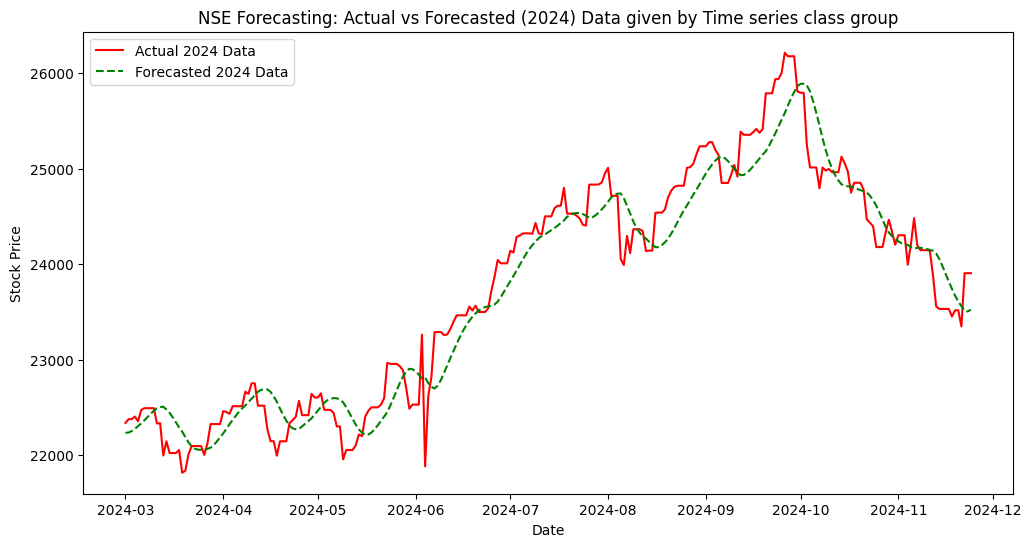

In [348]:
plt.figure(figsize=(12, 6))
# plt.plot(test_data.index[-len(actual_prices):], actual_prices, label='Actual 2024 Data', color='red')
# plt.plot(test_data.index[-len(forecasted_prices):], forecasted_prices, label='Forecasted 2024 Data', color='green', linestyle='--')
plt.plot(test_data.index[look_back : len(actual_prices) + look_back], actual_prices, label='Actual 2024 Data', color='red')
plt.plot(test_data.index[look_back : len(forecasted_prices) + look_back], forecasted_prices, label='Forecasted 2024 Data', color='green', linestyle='--')
plt.title('NSE Forecasting: Actual vs Forecasted (2024) Data given by Time series class group')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

**Residual Plot**:

Residuals follow Gaussian Distribution

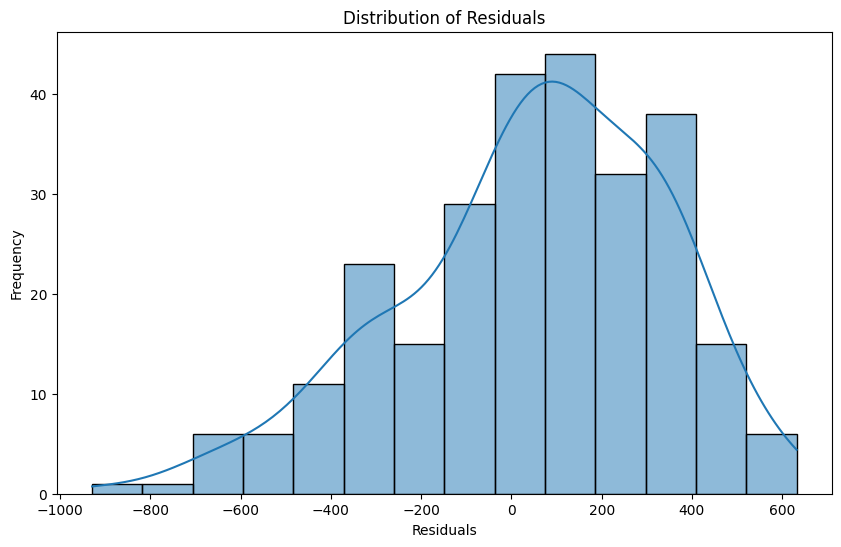

Runs test: zstat = -11.995846766890585, p-value = 3.735769915246563e-33


In [349]:
residuals = actual_prices - forecasted_prices

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Perform a runs test for randomness
from statsmodels.sandbox.stats.runs import runstest_1samp
zstat, pval = runstest_1samp(residuals)
print(f'Runs test: zstat = {zstat}, p-value = {pval}')

**MAE, RMSE, R^2 and MAPE**

These errors are under the acceptable limits for LSTM prediction when compared to AR, MA, ARIMA, and SARIMA

In [350]:
mae = mean_absolute_error(actual_prices, forecasted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, forecasted_prices))
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

r2 = r2_score(actual_prices, forecasted_prices)
print(f'R-squared (R^2): {r2}')

# Calculate MAPE
masked_actual = np.ma.masked_array(actual_prices, mask=actual_prices==0) #Mask values where y_true is 0 to avoid division by zero.
MAPE = (np.fabs(masked_actual.filled(0) - forecasted_prices)/masked_actual.filled(1)).mean() # forecasted_prices is already a numpy array. Removing .to_numpy()

print(f'MAPE: {MAPE}')

Mean Absolute Error (MAE): 240.63907556923792
Root Mean Squared Error (RMSE): 296.7571046793333
R-squared (R^2): 0.9368992794864583
MAPE: 0.010104579066308614


Facebook **Prophet Model**

In [351]:
!pip install prophet

from prophet import Prophet

# Assuming 'df' is your original DataFrame
data = df[['Fin_Dt', 'Close']].copy()  # Select date and closing price
data.columns = ['ds', 'y']  # Rename columns to 'ds' and 'y'

data['ds'] = pd.to_datetime(data['ds'])  # Ensure 'ds' is datetime

data.head()

,ds,y
Date,,
2015-11-09,2015-11-09,7915.20
2015-11-10,2015-11-10,7783.35
2015-11-11,2015-11-11,7825.00
2015-11-12,2015-11-12,7825.00
2015-11-13,2015-11-13,7762.25


In [352]:
# Create a Prophet model instance
prophet_model = Prophet()

# Fit the model to your data
prophet_model.fit(data)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zzf1fhr/ft3hn7pu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4zzf1fhr/4evbk9mm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41908', 'data', 'file=/tmp/tmp4zzf1fhr/ft3hn7pu.json', 'init=/tmp/tmp4zzf1fhr/4evbk9mm.json', 'output', 'file=/tmp/tmp4zzf1fhr/prophet_modelpqab0ymf/prophet_model-20241229151509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:15:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:15:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


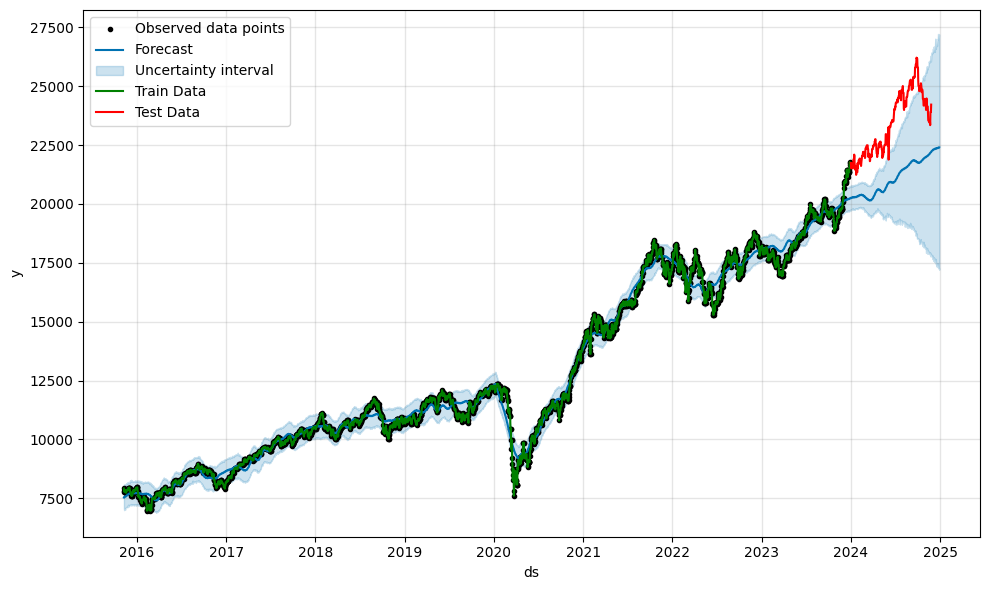

In [353]:
future = prophet_model.make_future_dataframe(periods=365)  # Forecast for 365 days ahead
future.tail()

forecast = prophet_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Plot the forecast
fig1 = prophet_model.plot(forecast)
plt.plot(train_data.index, train_data, label='Train Data', color='Green')
plt.plot(test_data.index, test_data, label='Test Data', color='red')
plt.legend()
plt.show()



In [354]:
# Evaluate the Prophet model

y_true = df_test['Close']
y_pred = forecast['yhat'][-len(y_true):]  # Align predictions with test data

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

r2 = r2_score(y_true, y_pred)
print(f'R-squared (R^2): {r2}')

# Calculate MAPE
masked_actual = np.ma.masked_array(y_true, mask=y_true==0) #Mask values where y_true is 0 to avoid division by zero.
MAPE = (np.fabs(masked_actual.filled(0) - y_pred)/masked_actual.filled(1)).mean() # forecasted_prices is already a numpy array. Removing .to_numpy()

print(f'MAPE: {MAPE}')


Mean Absolute Error (MAE): 2168.09092294898
Root Mean Squared Error (RMSE): 2301.239045231376
R-squared (R^2): -2.0627859454426796
MAPE: 0.09132958065376988


we can conclude **Rolling ARIMA is the most accurate model for forecasting **the stock data . It has a R - Squared value close to 1  and the least mean absolute error **among the models tested** . The mean absolute percentage error is also marginal when compared to the other outputs . However , rolling ARIMA requires refitting the model at each time step, which can be computationally expensive and time-consuming, especially with large datasets or when making many predictions. We have taken a 7 day window for predicting stock prices but the results will vary if we take a 30 day window . There is an inherent  risk of overfitting when using a 7 day window .

LSTM is the closest alternative to rolling ARIMA . The model metrics are relatively worse but much better than the other model alternatives taken .  **Since LSTM trains in batches , it's much more computationally forgiving than rolling ARIMA**  . Variants of LSTM  can be used to gain model performance improvements over the standard Sequential LSTM .
